## Use Fuzzing Book Resources

In [4]:
import bookutils
from typing import List, Tuple, Dict, Any
from Fuzzer import RandomFuzzer
from Coverage import Coverage
import pickle
import hashlib

# Create simple fuzzer
fuzzer = RandomFuzzer(
    min_length=1, max_length=100, char_start=32, char_range=94
)


from html.parser import HTMLParser
# Create simple program-under-test
def my_parser(inp: str) -> None:
    parser = HTMLParser()
    parser.feed(inp)


def getTraceHash(cov: Coverage) -> str:
    pickledCov = pickle.dumps(cov.coverage())
    hashedCov = hashlib.md5(pickledCov).hexdigest()
    return hashedCov


# Every program path is a color
inp = "asdf"

with Coverage() as cov:
    my_parser(inp)
# cov.coverage()
getTraceHash(cov)

'6531c9b63011e6232ac87ac053d93fc3'

# **The rarity differs for different coverage**

### Use the fuzzer to create a population

In [5]:
trials = 50000

population = []
for i in range(trials):
    population.append(fuzzer.fuzz())

population[:3]

['"N&+slk%hyp5o\'@[3(rW*M5W]tMFPU4\\P@tz%[X?uo\\1?b4T;1bDeYtHx #UJ5w}pMmPodJM,_%%',
 'CdYN6*g|Y*Ou9I<P94}7,99ivb(9`=%jJj*',
 "*dOLXk!;Jw!iOU8]hqg00?u(c);>:\\=V<ZV1=*g#UJA'No5QZ)--[})Sdv"]

### Record the frequency of each coverage

In [6]:
# TODO: Implement the code to calculate the coverage of the population

############# IMPLEMENT HERE #############
all_coverage_dict = {}
for inp in population:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except:
            pass
    cov_hash = getTraceHash(cov)
    if cov_hash not in all_coverage_dict:
        all_coverage_dict[cov_hash] =0
    all_coverage_dict[cov_hash] +=1 
##########################################


### Distribution of the coverage

Number of unique traces: 432
Top 3 frequencies: [20363, 5504, 5342]
Bottom 3 frequencies: [1, 1, 1]


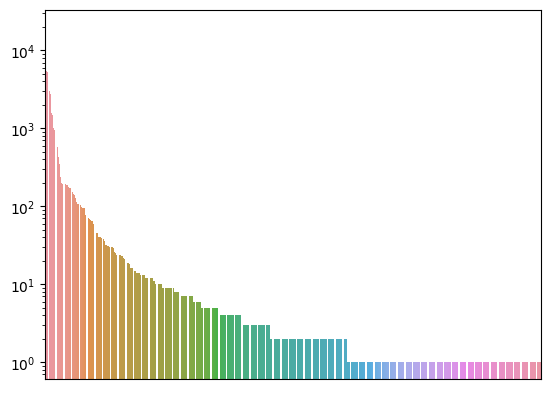

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

num_unique = len(all_coverage_dict)
print(f"Number of unique traces: {num_unique}")
print(
    f"Top 3 frequencies: {sorted(list(all_coverage_dict.values()), reverse=True)[:3]}"
)
print(f"Bottom 3 frequencies: {sorted(list(all_coverage_dict.values()))[:3]}")
freqs = sorted(list(all_coverage_dict.values()), reverse=True)
# print bar chart of the frequencies
fig, ax = plt.subplots()
sns.barplot(x=list(range(len(freqs))), y=freqs, ax=ax)
# remove the x labels
ax.set_xticks([])
# set log-scale for y-axis
ax.set_yscale("log")
plt.show()

## Some Definitions

- Singletons: colors that appear only once in the sample
- Doubletons: colors that appear twice in the sample

$$
\Phi_k = \text{the number of colors that appear $k$ times in the sample}
$$

- $\Phi_1$ = the number of singletons, $\Phi_2$ = the number of doubletons, etc.

In [8]:
# TODO: Compute the singletons and doubletons

############# IMPLEMENT HERE #############
singletons = {k: v for k, v in all_coverage_dict.items() if v == 1}
doubletons = {k: v for k, v in all_coverage_dict.items() if v == 2}
##########################################

print(
    "The number of coverage elements seen exactly once is "
    + str(len(singletons))
)
print(
    "The number of coverage elements seen exactly twice is "
    + str(len(doubletons))
)

The number of coverage elements seen exactly once is 169
The number of coverage elements seen exactly twice is 67


***💡 Go back to the slides***

# **Missing Mass**: What is the probability that the next generated input increases coverage?

### Estimating the propobability of generating a coverage-increasing input

- **Good-Turing** estimator:
$$
\hat{M_0} = \frac{\Phi_1}{n}
$$

In [9]:
# TODO: Implement the Good-Turing estimator

############# IMPLEMENT HERE #############
estimate = len(singletons) / trials
##########################################

print(
    "The probability that the next input increases coverage is estimated as "
    + str(estimate)
)

The probability that the next input increases coverage is estimated as 0.00338


### How do we evaluate this?

In [10]:
# TODO: Evaluate the estimator empirically

############# IMPLEMENT HERE #############
curr_coverage = all_coverage_dict.keys()

validation = []
for i in range(trials):
    validation.append(fuzzer.fuzz())

count = 0
for inp in validation:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except:
            pass
    this_coverage = set([getTraceHash(cov)])
    if len(curr_coverage & this_coverage) == 0:
        count += 1

empirical = count / trials
##########################################

print(
    "The probability that the next input increases coverage is empirically "
    + str(empirical)
)

The probability that the next input increases coverage is empirically 0.00334


## Why does Good-Turing work so well?

Intuitive explanation: "if you observe a new thing at this round, it becomes one of the singletons at the next round."

***💡 Go back to the slides for a little bit deeper explanation :)***

# **Species Richness**: What is the maximum coverage we can achieve?

The estimate of the lower bound of the remaining coverage is
$$
\frac{n - 1}{n}\frac{(\Phi_1)^2}{2\Phi_2}
$$

In [11]:
# TODO: Estimate the Species Richness

############# IMPLEMENT HERE #############
estimate = int((trials - 1) / trials * (len(singletons) ** 2) / (2 * len(doubletons)))
##########################################

print(
    f"The lower bound of the number of coverages that are still unexplored is {estimate}"
)

The lower bound of the number of coverages that are still unexplored is 213


### How do we evaluate this?

Let's try to run the fuzzer much longer and see if we can reach the estimate.

In [12]:
# TODO: Evaluate the estimator by empirically observing 
#       the number of new coverages for a large number of inputs

############# IMPLEMENT HERE #############
extra_coverage = trials * 2
validation = []
for i in range(extra_coverage):
    validation.append(fuzzer.fuzz())

extra_coverage = set()
for inp in validation:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except:
            pass
    cov_hash = set([getTraceHash(cov)])
    extra_coverage |= cov_hash

extra_coverage -= curr_coverage
##########################################

print(f"Number of new coverages: {len(extra_coverage)}")

Number of new coverages: 226


***💡 Go back to the slides***

# **Extrapolation**: How much can I discover more when I spend $X$ more time here?

- $\Delta(m)$: the number of new discoveries when $m$ more samples are retrieved.

$$
\hat \Delta(m) = \hat \Phi_0 \left[1 - \left(1 - \frac{\Phi_1}{n\hat \Phi_0 + \Phi_1} \right)^m\right]
$$

### Show the coverage increase with the number of samples.

- Compute the cumulative coverage of the population with size 200,000 + (additional) 200,000
- Extrapolate the number of unique coverage from the point where we have 200,000 samples.

In [13]:
############################################################
# First 200,000 inputs
############################################################
trials = 200000
population = []
for i in range(trials):
    population.append(fuzzer.fuzz())

cumulative_coverage = []
all_coverage = set()
singletons = set()  # Store the number of singletons 
doubletons = set()  # and doubletons for the extrapolation

for inp in population:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    this_coverage = set([getTraceHash(cov)])
    doubletons -= this_coverage
    doubletons |= singletons & this_coverage
    singletons -= this_coverage
    singletons |= this_coverage - all_coverage
    all_coverage |= this_coverage
    cumulative_coverage.append(len(all_coverage))

num_singletons = len(singletons)
num_doubletons = len(doubletons)

############################################################
# Additional 200,000 inputs
############################################################
extra_trials = 200000
validation = []
for i in range(extra_trials):
    validation.append(fuzzer.fuzz())

for inp in validation:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    this_coverage = set([getTraceHash(cov)])
    all_coverage |= this_coverage
    cumulative_coverage.append(len(all_coverage))


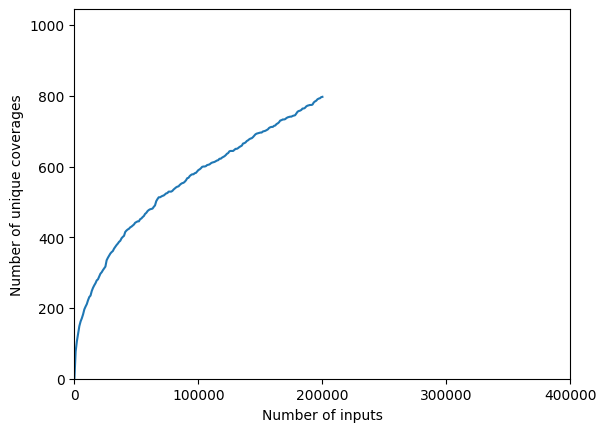

In [14]:
fig, ax = plt.subplots()
coverage_ateach_1000trial = [0] + cumulative_coverage[
    999::1000
]  # for every 1000 trials
sub_coverage_until_half = coverage_ateach_1000trial[:201]
sns.lineplot(
    x=range(0, 200001, 1000),
    y=sub_coverage_until_half,
    ax=ax,
)
ax.set_xlim(0, 400000)
ax.set_ylim(0, cumulative_coverage[-1])
ax.set_xticks([0, 100000, 200000, 300000, 400000])
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Number of unique coverages")
plt.show()

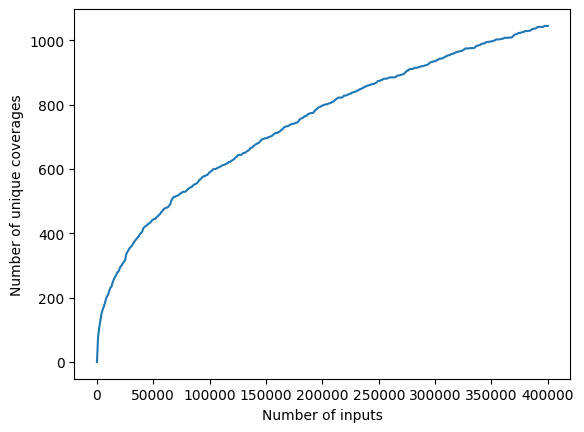

In [15]:
fig, ax = plt.subplots()
sns.lineplot(
    x=range(0, 400001, 1000),
    y=coverage_ateach_1000trial,
    ax=ax,
)
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Number of unique coverages")
plt.show()

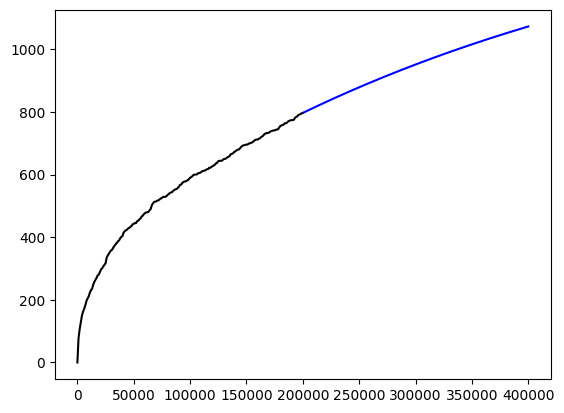

In [18]:
## formula:
## - \Phi_0 = (n - 1) / n * (\Phi_1^2 / (2 \Phi_2))
## - \Delta(m) = \Phi_0 [1 - (1 - \Phi_1/(n \Phi_0 + \Phi_1) )^m ]

############# IMPLEMENT HERE #############
phi1 = num_singletons
phi2 = num_doubletons
phi0 = (trials - 1) / trials * (phi1**2 / (2 * phi2))
extrapolator = lambda m: phi0 * (1 - (1 - phi1 / (trials * phi0 + phi1)) ** m)

extrapolated = [extrapolator(i) for i in range(1, 200001)]
extrapolated = [d + sub_coverage_until_half[-1] for d in extrapolated]
##########################################

fig, ax = plt.subplots()
sns.lineplot(
    x=range(0, 200001, 1000),
    y=sub_coverage_until_half,
    ax=ax,
    color="black",
)
sns.lineplot(
    x=range(201000, 400001, 1000),
    y=extrapolated[999::1000],
    ax=ax,
    color="blue",
    dashes=True,
)

plt.show()

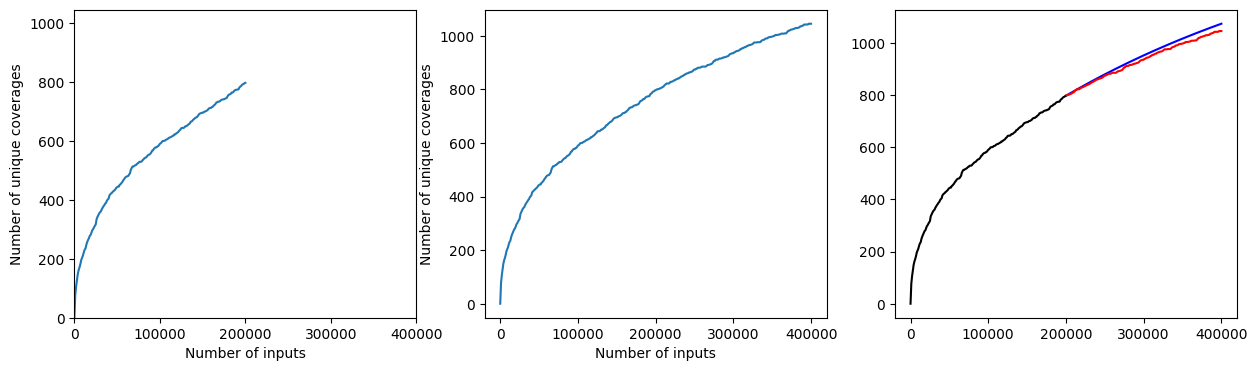

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1.
sns.lineplot(
    x=range(0, 200001, 1000),
    y=sub_coverage_until_half,
    ax=axes[0],
)
axes[0].set_xlim(0, 400000)
axes[0].set_ylim(0, cumulative_coverage[-1])
axes[0].set_xticks([0, 100000, 200000, 300000, 400000])
axes[0].set_xlabel("Number of inputs")
axes[0].set_ylabel("Number of unique coverages")

# 2.
sns.lineplot(
    x=range(0, 400001, 1000),
    y=coverage_ateach_1000trial,
    ax=axes[1],
)
axes[1].set_xlabel("Number of inputs")
axes[1].set_ylabel("Number of unique coverages")

# 3.
sns.lineplot(
    x=range(0, 200001, 1000),
    y=sub_coverage_until_half,
    ax=axes[2],
    color="black",
)
sns.lineplot(
    x=range(201000, 400001, 1000),
    y=extrapolated[999::1000],
    ax=axes[2],
    color="blue",
    dashes=True,
)
sns.lineplot(
    x=range(201000, 400001, 1000),
    y=coverage_ateach_1000trial[201:],
    ax=axes[2],
    color="red",
)

plt.show()

***💡 Go back to the slides***

# **Reaching Probability**: What is the probability of reaching a specific program element?

### Let's consider an example of the control flow graph of a program.

Starting from small one with five statements.

In [ ]:
from bn import SimpleBN
import numpy as np

np.random.seed(0)
sbn = SimpleBN(5)
display(sbn.draw())
min_prob = min(sbn.reach_prob_dict.values())
min_nidx = min(sbn.reach_prob_dict, key=sbn.reach_prob_dict.get)
print(f"Min prob: {min_prob} at node {min_nidx}")


Of course, there's some issue with using the bayesian network for CFGs.
- Using the bayesian network for CFGs means the branch conditions are independent.
- Which is not true in general.
  
But, it's a fair approximation for the exercises :)

Edge list:

In [ ]:
display(sbn.edgeidx2edge)

Generate execution

In [ ]:
sbn.gen_obss(1)[0]

In [ ]:
edge_cov = sbn.gen_obss(20)
display(edge_cov)

node_cov = sbn.edgecov2nodecov(edge_cov)
display(node_cov)

covered_nodes = np.logical_or.reduce(node_cov, 0).astype(np.int8)
covered_node_idxs = np.nonzero(covered_nodes)[0]
display(covered_node_idxs)

Let's consider a little bit bigger program.

In [ ]:
sbn = SimpleBN(30)
display(sbn.draw())
min_prob = min(sbn.reach_prob_dict.values())
min_nidx = min(sbn.reach_prob_dict, key=sbn.reach_prob_dict.get)
print(f"Min prob: {min_prob} at node {min_nidx}")


In [ ]:
num_exec = 1000
edge_cov = sbn.gen_obss(num_exec)
node_cov = sbn.edgecov2nodecov(edge_cov)
coverage_freq = np.sum(node_cov, 0)
coverage_freq_dict = {i: coverage_freq[i] for i in range(len(coverage_freq))}
print("Coverage frequencies:")
display(coverage_freq_dict)
covered_nodes = coverage_freq > 0
covered_node_idxs = set(np.nonzero(covered_nodes)[0])
uncovered_node_idxs = set(np.nonzero(1 - covered_nodes)[0])
print("Uncovered nodes:", sorted(uncovered_node_idxs))
for node_idx in sorted(uncovered_node_idxs):
    print(f"Pr({node_idx}) = {sbn.reach_prob_dict[node_idx]}")

### Blackbox estimation

In [ ]:
# Laplace estimator
alpha = 2
esti_laplace = 2 / (num_exec + 4)

# Good-Turing estimator
edge_cov_str = ["".join(map(str, row)) for row in edge_cov]
edge_cov_freq = {edge: edge_cov_str.count(edge) for edge in set(edge_cov_str)}
singletons = {k: v for k, v in edge_cov_freq.items() if v == 1}
est_goodturing = len(singletons) / num_exec

print(f"Estimated Laplace: {esti_laplace}")
print(f"Estimated Good-Turing: {est_goodturing}")

### Structure-aware estimation

For each uncovered statement,
1. find the set of closest reached statements
2. for each of them
   1. find the set of paths from the closest reached statement to the uncovered statement only through the uncovered statements
   2. compute the probability through the paths
3. sum the probabilities

In [ ]:
uncovered_node = sorted(uncovered_node_idxs)[0]
print(f"Node {uncovered_node} is uncovered.")

ancestor_nodes = sbn.get_ancestors(uncovered_node)
print(f"Ancestor nodes: {ancestor_nodes}")

############# IMPLEMENT HERE #############
reached_ancestor_nodes = None
print(f"Reached ancestor nodes: {reached_ancestor_nodes}")
##########################################

In [ ]:
def find_closest_reached_ancestor(
    target_node: int, reached_ancestor_nodes: set, sbn: SimpleBN
) -> int:
    if target_node in reached_ancestor_nodes:
        return {target_node}
    
    ############# IMPLEMENT HERE #############
    closest = set()
    ##########################################
    
    return closest


closest_reached_ancestors = find_closest_reached_ancestor(
    uncovered_node, reached_ancestor_nodes, sbn
)

print(f"Closest reached ancestor nodes: {closest_reached_ancestors}")

In [ ]:
def find_paths(
    source_node: int, target_node: int, avoid_nodes: List[int], sbn: SimpleBN
):
    ############# IMPLEMENT HERE #############
    paths = []
    queue = [[source_node]]
    ##########################################
    
    return paths

for cra in sorted(closest_reached_ancestors):
    paths = find_paths(cra, uncovered_node, covered_node_idxs, sbn)
    print(f"Paths from {cra} to {uncovered_node}: {paths}")

In [ ]:
def compute_prob(path: list, sbn: SimpleBN, n: int, start_freq: int) -> float:
    ############# IMPLEMENT HERE #############
    prob = start_freq / n  # empirical reaching probability of the start node
    ##########################################

    return prob


total_prob = 0
for cra in sorted(closest_reached_ancestors):
    paths = find_paths(cra, uncovered_node, covered_node_idxs, sbn)
    for path in paths:
        prob = compute_prob(path, sbn, num_exec, coverage_freq_dict[cra])
        print(f"Probability of path {path}: {prob}")
        total_prob += prob
print(f"Total probability of reaching node {uncovered_node}: {total_prob}")

In [ ]:
# Another one

uncovered_node = None
print(f"Node {uncovered_node} is uncovered.")

ancestor_nodes = sbn.get_ancestors(uncovered_node)
print(f"Ancestor nodes: {ancestor_nodes}")

reached_ancestor_nodes = ancestor_nodes & covered_node_idxs
print(f"Reached ancestor nodes: {reached_ancestor_nodes}")

closest_reached_ancestors = find_closest_reached_ancestor(
    uncovered_node, reached_ancestor_nodes, sbn
)
print(f"Closest reached ancestor nodes: {closest_reached_ancestors}")

total_prob = 0
for cra in sorted(closest_reached_ancestors):
    paths = find_paths(cra, uncovered_node, covered_node_idxs, sbn)
    print(f"Paths from {cra} to {uncovered_node}: {paths}")
    for path in paths:
        prob = compute_prob(path, sbn, num_exec, coverage_freq_dict[cra])
        print(f"Probability of path {path}: {prob}")
        total_prob += prob
print(f"Total probability of reaching node {uncovered_node}: {total_prob}")

In [ ]:
def structure_aware_esti(
    uncovered_node: int, sbn: SimpleBN, coverage_freq_dict
):
    ancestor_nodes = sbn.get_ancestors(uncovered_node)
    covered_node_idxs = {k for k, v in coverage_freq_dict.items() if v > 0}
    reached_ancestor_nodes = ancestor_nodes & covered_node_idxs
    closest_reached_ancestors = find_closest_reached_ancestor(
        uncovered_node, reached_ancestor_nodes, sbn
    )
    num_exec = sum([v for k, v in coverage_freq_dict.items()])
    total_prob = 0
    for cra in sorted(closest_reached_ancestors):
        remaining_cras = closest_reached_ancestors - {cra}
        paths = find_paths(cra, uncovered_node, remaining_cras, sbn)
        for path in paths:
            prob = compute_prob(path, sbn, num_exec, coverage_freq[cra])
            total_prob += prob
    return total_prob

In [ ]:
import pandas as pd

df = pd.DataFrame(
    {
        "node": sorted(uncovered_node_idxs),
        "true": [sbn.reach_prob_dict[n] for n in sorted(uncovered_node_idxs)],
        "lap": [esti_laplace] * len(uncovered_node_idxs),
        "good": [est_goodturing] * len(uncovered_node_idxs),
        "struct": [
            structure_aware_esti(n, sbn, coverage_freq_dict)
            for n in sorted(uncovered_node_idxs)
        ],
    }
)
display(df)

# draw barplot
df_melt = df.melt(id_vars="node", var_name="method", value_name="prob")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="node", y="prob", hue="method", data=df_melt, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="node", y="prob", hue="method", data=df_melt, ax=ax)
ax.set_yscale("log")
plt.show()

***💡 Go back to the slides***